In [1]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform
import os
import json

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
domain= anuga.create_domain_from_file('/home/ZhiLi/mesher/examples/Harris/stream_dem/DEM_10m.mesh')

[]


In [3]:
# topography_file = '/hydros/ZhiLi/demHouston033s_NAm83fel.tif'
topography_file = '/hydros/ZhiLi/DEM_10m_Harris_fill.tif'

Figure files for each frame will be stored in _plot


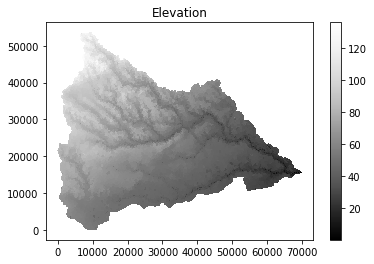

In [4]:
start= '20170825000000'
end= '20170825010000'
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', filename='/home/ZhiLi/CRESTHH/data/Texas_friction/manningn.tif', location='centroids')
domain.quantities['friction'].centroid_values[:]*=0
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SM', 0.8, location='centroids')
domain.set_quantity('Ksat', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/ksat.tif', location='centroids')
domain.set_quantity('WM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/wm_10m.tif', location='centroids')
domain.set_quantity('B', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/b_10m.tif', location='centroids')
domain.set_quantity('IM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/im.tif', location='centroids')
domain.set_quantity('KE', 0.89, location='centroids')
domain.set_coupled(True)

domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/synthetic_rainfall',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='2M')
domain.set_timestamp(start, format='%Y%m%d%H%M%S')
domain.set_time_interval('2M')
domain.set_name('coupled_10m_modified_mesh')
total_seconds= (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds()
dplotter = anuga.Domain_plotter(domain)
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')

plt.colorbar();
plt.title("Elevation");

In [5]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'interior': Br,
                     'exterior': Bi})

In [6]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=120, duration=3600*3)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0, vmax=30)

    domain.print_timestepping_statistics(track_speeds=False)

    rain= domain.get_quantity('P').centroid_values
    ET= domain.get_quantity('ET').centroid_values
    exc_rain= domain.get_quantity('excess_rain').centroid_values
    soil= domain.get_quantity('SM').centroid_values
    print 'rain: %f; ET: %f; excessive_rain: %f; soil: %f'%(rain[100]*1000, ET[100]*1000, exc_rain[100]*1000, soil[100]*100)
    stage = domain.get_quantity('stage')
    print 'friction: ',domain.get_quantity('friction').centroid_values[100]
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation()

Time = 2017-08-25 00:00:00, steps=0 (45s)
rain: 0.000000; ET: 0.000000; excessive_rain: 0.000000; soil: 80.000000
friction:  0.0
integral =  0.0
Time = 2017-08-25 00:02:00, delta t = 1000.00000000, steps=1 (5s)
rain: 0.027778; ET: 0.000016; excessive_rain: 0.000000; soil: 80.000000
friction:  0.0
integral =  0.0
Time = 2017-08-25 00:04:00, delta t = 1000.00000000, steps=1 (6s)
rain: 0.027778; ET: 0.000016; excessive_rain: 0.018919; soil: 83.487634
friction:  0.0
integral =  4315489.629600227
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww coul

DataFileNotOpenError: File ./coupled_10m_modified_mesh.sww could not be opened for append

rain

from cresthh.anuga import SWW_plotter

splotter= SWW_plotter('coupled_10m_modified_mesh.sww')

plt.figure(figsize=(15,8))
# splotter.triang.set_mask(splotter.depth.mean(axis=0) > 0.1)
# plt.tripcolor(splotter.triang,
#               facecolors=splotter.elev,
#               cmap='gray')
splotter.triang.set_mask(splotter.depth.mean(axis=0) <= 0.1)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.depth).mean(axis=0),
              cmap='Blues',
             vmin=0.1,
             vmax=2)
plt.colorbar()

plt.figure(figsize=(15,8))
splotter.triang.set_mask(splotter.speed.max(axis=0) > 0.1)
plt.tripcolor(splotter.triang,
              facecolors=splotter.elev,
              cmap='viridis')
splotter.triang.set_mask(splotter.speed.max(axis=0) <= 0.1)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.speed).max(axis=0),
              cmap='jet',
             vmin=0,
             vmax=2)
plt.colorbar()